## Convolutional Neural Networks for Classifying Melanoma Images

##### Nikhilkumar Patel

Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Reading/Understanding

### Importing all the important libraries

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure you resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset= 'training',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

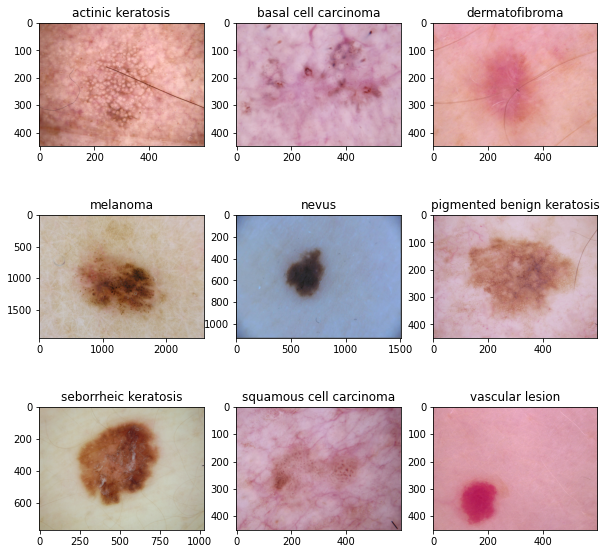

In [11]:
import matplotlib.pyplot as plt

### Code to use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 281s 1s/step - loss: 2.0570 - accuracy: 0.1970 - val_loss: 2.0320 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 2.0149 - accuracy: 0.2282 - val_loss: 1.8722 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 2.0160 - accuracy: 0.2288 - val_loss: 2.0273 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0174 - accuracy: 0.2076 - val_loss: 2.0268 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9694 - accuracy: 0.2321 - val_loss: 2.0097 - val_accuracy: 0.2371
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.9818 - accuracy: 0.2299 - val_loss: 1.9598 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9721 - accuracy: 0.2506 - val_loss: 2.0548 - val_accuracy: 0.2058
Epoch 8/20
56

### Visualizing training results

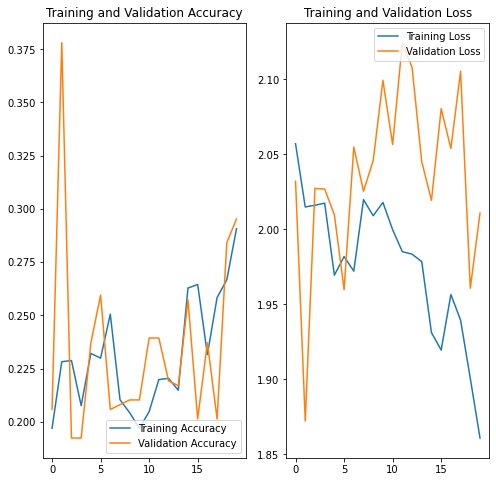

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit

### Finding from the above outputs

* Model is overfitting because there is a difference in loss function in training & test in some epochs
* Accuracy is very less because there are enough features to remember the pattern

In [18]:
# Model fit history for presence of overfit, Choosing data augmentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

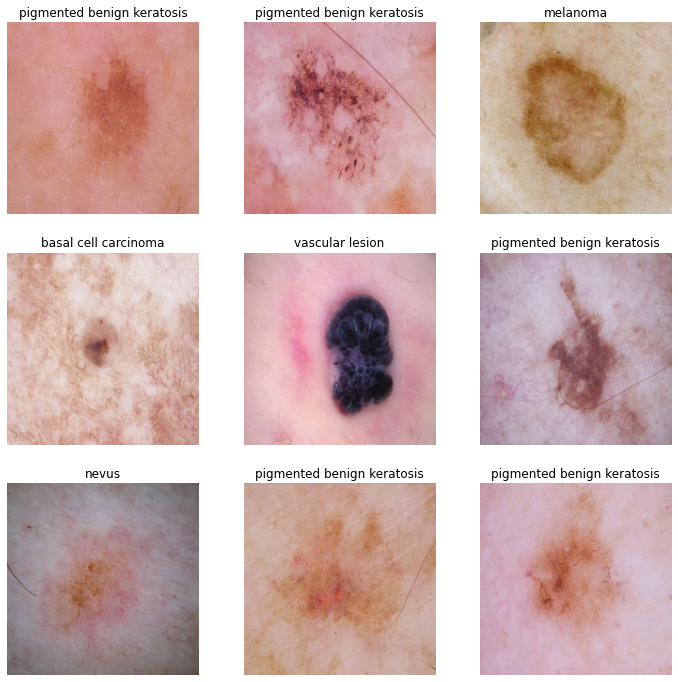

In [19]:
# visualize how augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
##  train model for 20 epochs
##  train model for 20 epochs
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 91ms/step - loss: 2.0567 - accuracy: 0.1881 - val_loss: 2.0447 - val_accuracy: 0.2304
Epoch 2/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0275 - accuracy: 0.2003 - val_loss: 2.0307 - val_accuracy: 0.1924
Epoch 3/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0227 - accuracy: 0.1925 - val_loss: 2.0226 - val_accuracy: 0.2058
Epoch 4/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0174 - accuracy: 0.2132 - val_loss: 2.0397 - val_accuracy: 0.1924
Epoch 5/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0193 - accuracy: 0.1987 - val_loss: 2.0282 - val_accuracy: 0.1924
Epoch 6/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0206 - accuracy: 0.2087 - val_loss: 2.0295 - val_accuracy: 0.2081
Epoch 7/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0212 - accuracy: 0.2031 - val_loss: 2.0308 - val_accuracy: 0.2081
Epoch 8/30
56/56 [======

### Visualizing the results

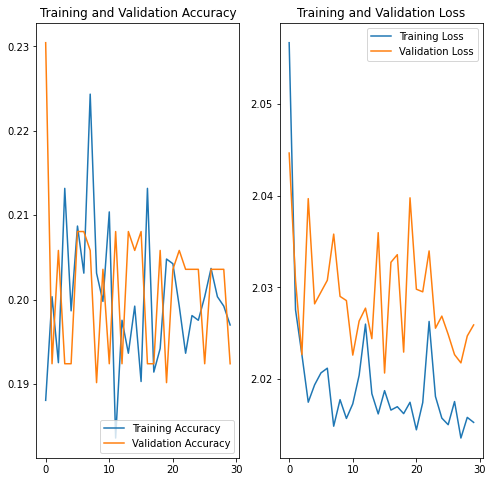

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* No significant improvement in accuracy but overfitting problem has solved due to the augmentation
* May be increasing the epochs can improve accuracy

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion


In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion


<BarContainer object of 9 artists>

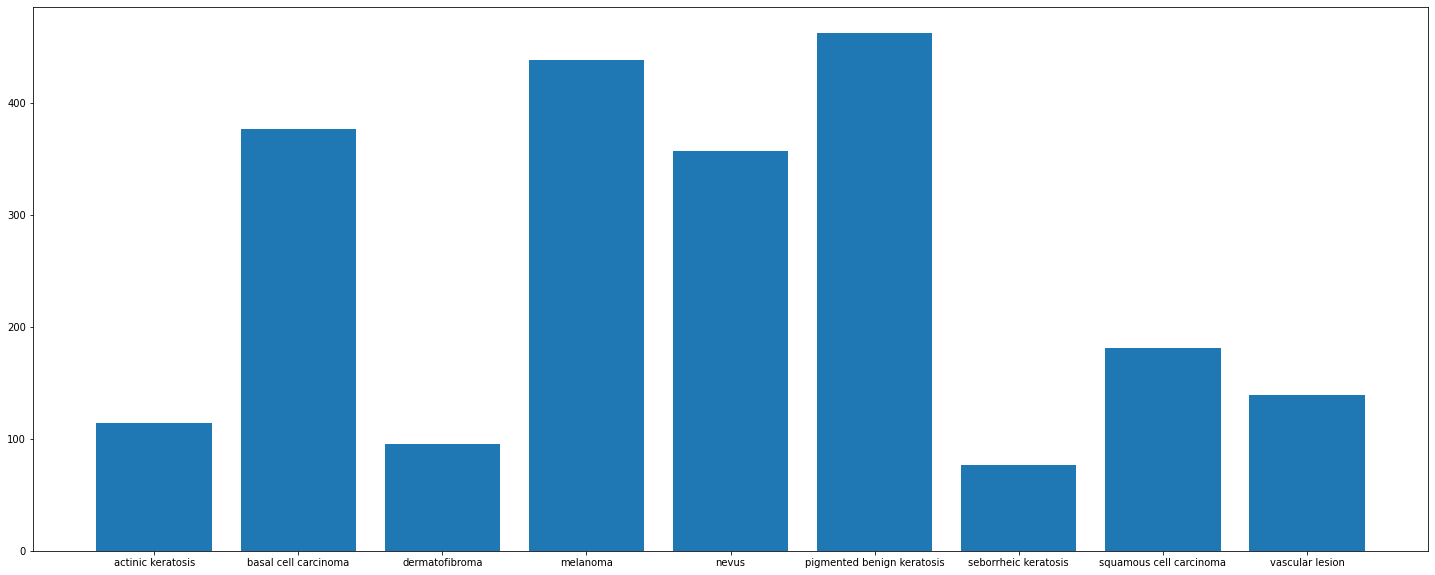

In [26]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings: 
#### - Which class has the least number of samples?
[Answer] seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
[Answer] melonama & pigmented benign keratosis dominate


In [27]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F8C4D0D50>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F8C49D290>: 100%|██████████| 500/500 [00:17<00:00, 28.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F8C4B6550>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F9F8C47C7D0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1008x711 at 0x7F9EF6720950>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F8807E310>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F8C4B6910>: 100%|██████████| 500/500 [00:40<00:00, 12.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F88064810>: 100%|██████████| 500/500 [00:17<00:00, 28.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F8C9AE210>: 100%|██████████| 500/500 [00:17<00:00, 28.31 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
# print(data_dir_train)
# print(data_dir_train.glob(os.path.join(data_dir_train, '*','output', '*.jpg')))

['/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_16417d9f-3588-4652-9d89-49dfe2d04e4a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_98866871-e59a-47a4-b641-6eb47f359357.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_7f992157-517a-40bd-87e1-da65bb9e3045.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028346.jpg_d8e98768-cf49-48e5-8168-88945993b098.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028735.jpg_a40a0ef4-1355-4c71-aeda-ee6cefc74a94.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_920fb19e-395e-43ac-a5d8-8907fcf732db.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output/dermatofibrom

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [49]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [51]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [53]:
data_dir_train1="/content/drive/MyDrive/Colab Notebooks/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model including normalization

In [55]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compile model by choosing optimizer and loss function appropriately

In [56]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [57]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 34s 191ms/step - loss: 2.1869 - accuracy: 0.1335 - val_loss: 2.1966 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 33s 187ms/step - loss: 2.1622 - accuracy: 0.1582 - val_loss: 2.1203 - val_accuracy: 0.1938
Epoch 3/50
169/169 [==============================] - 32s 184ms/step - loss: 2.1426 - accuracy: 0.1691 - val_loss: 2.1179 - val_accuracy: 0.1915
Epoch 4/50
169/169 [==============================] - 32s 183ms/step - loss: 2.1289 - accuracy: 0.1834 - val_loss: 2.0977 - val_accuracy: 0.1871
Epoch 5/50
169/169 [==============================] - 33s 190ms/step - loss: 2.1122 - accuracy: 0.1984 - val_loss: 2.1700 - val_accuracy: 0.1604
Epoch 6/50
169/169 [==============================] - 32s 183ms/step - loss: 2.1542 - accuracy: 0.1786 - val_loss: 2.1474 - val_accuracy: 0.1707
Epoch 7/50
169/169 [==============================] - 32s 184ms/step - loss: 2.1093 - accuracy: 0.1829 - val_loss: 2.0801 - val_accuracy: 0.1

#### **Todo:**  Visualize the model results

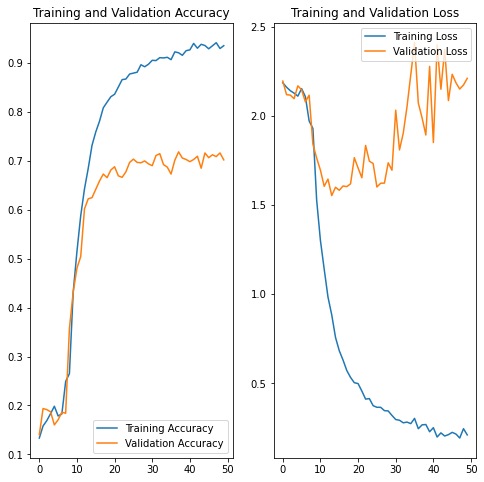

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* Accuracy on training data has increased by using Augmentor library
* Model is still overfitting
* Overfitting can be solved by adding more new layers or dropout layers
* Also, model can be improved by tuning the hyperparameter

## Testing the model on Test Image set (one example)

In [82]:
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Test/actinic keratosis/ISIC_0010512.jpg',target_size=(180,180))
img = image.img_to_array(img)
img = img/255.0

In [83]:
proba = model.predict(img.reshape(1,180,180,3))
top_9 = np.argsort(proba[0])[:-10:-1]


pigmented benign keratosis (0.181)
melanoma (0.166)
dermatofibroma (0.135)
squamous cell carcinoma (0.109)
seborrheic keratosis (0.109)
nevus (0.0951)
vascular lesion (0.0865)
actinic keratosis (0.0805)
basal cell carcinoma (0.0388)


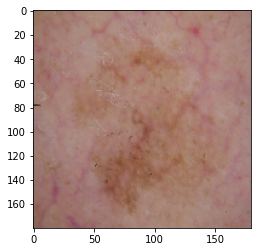

In [84]:
for i in range(9):
    print("{}".format(class_names[top_9[i]])+" ({:.3})".format(proba[0][top_9[i]]))
plt.imshow(img)